<a href="https://colab.research.google.com/github/su-nitin/Regression/blob/main/linearRegression(Eq%26Optimization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data operations

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
import seaborn as sns
np.random.seed(5)

In [2]:
df = pd.read_excel('/content/Energy efficiency.xlsx')
print(df.shape)

(768, 10)


In [3]:
#check for missing values
print(np.sum(df.isna()))

relative compactness         0
surface area                 0
wall area                    0
roof area                    0
overall height               0
orientation                  0
glazing area                 0
glazing area distribution    0
heating load                 0
cooling load                 0
dtype: int64


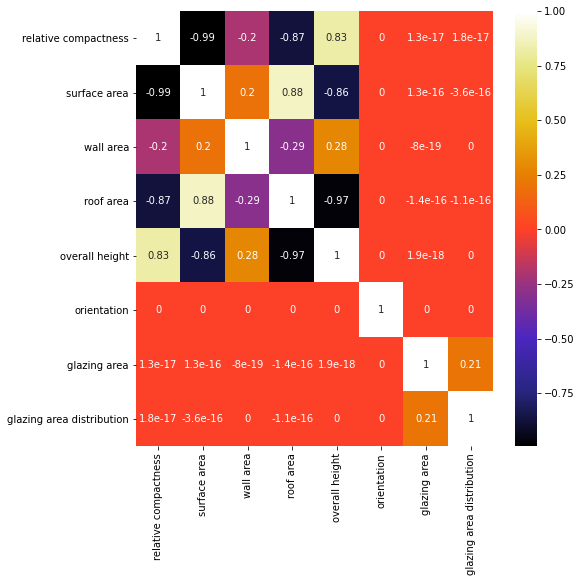

Index(['relative compactness', 'surface area', 'wall area', 'roof area',
       'overall height', 'orientation', 'glazing area',
       'glazing area distribution'],
      dtype='object')


In [4]:
# feature selection

# feature co-relation
df_corr = df.iloc[:, :df.shape[1]-2].corr()
plot = plt.figure(figsize=(8,8)).add_subplot(111)
sns.heatmap(df_corr, cmap='CMRmap', annot=True, cbar=True, ax=plot)
plt.show()
print(df_corr.columns)

In [5]:
# removing co-related features
selected_x = ['surface area', 'wall area', 'overall height', 'orientation', 'glazing area']
# dataset
data = df.loc[:, selected_x]
targets = df.iloc[:, df.shape[1]-2:]

In [6]:
# scaling
def std_scale(data):
  sem = data.shape
  mu = np.ones((sem[0], sem[1])) * list(data.mean())
  sigma = np.ones((sem[0], sem[1])) * list(data.std())
  return np.abs(data - mu) / sigma
data = std_scale(data)

# padding with one column for bias
data.insert(0, 'bias', np.ones((data.shape[0], 1)))
data.head()

,bias,surface area,wall area,overall height,orientation,glazing area
0,1.0,1.784712,0.561586,0.999349,1.340767,1.7593
1,1.0,1.784712,0.561586,0.999349,0.446922,1.7593
2,1.0,1.784712,0.561586,0.999349,0.446922,1.7593
3,1.0,1.784712,0.561586,0.999349,1.340767,1.7593
4,1.0,1.228438,0.000000,0.999349,1.340767,1.7593


In [7]:
# data split
m = data.shape[0]
split = int(0.8*m)
# shuffling indices
shuff_ind = np.arange(0,m,1)
np.random.shuffle(shuff_ind)
train_ind = shuff_ind[:split+1]
test_ind = shuff_ind[split+1:]

xTrain = data.iloc[train_ind, :]
xTest = data.iloc[test_ind, :]
yTrain = targets.iloc[train_ind, 0]
yTest = targets.iloc[test_ind, 0]

#Live plot function

In [8]:
def show_optim(optimfig, optimax, loss, iter, buff=50):
  '''
  fig: figure to draw
  ax: axis 
  loss: list of cost/losses got during training
  iter: maximum iterations
  buff: default = 50, defines number of frames and values to choose 
  list of loss. 
  [Warning : Expect degraded performance and longer wait times on buff > 50]
  '''
  if iter > 50:
    size = iter - iter%buff
  else:
    size = iter
  step = int(np.floor(size / buff))
  m = list(range(iter))

  def animate(i):
    if i < iter-1:
      optimax.plot(m[i+step], loss[i+step], 'b+', linewidth=3, markersize=4)
  return animation.FuncAnimation(optimfig, animate, frames=buff)

#Linear Regression Functions


In [9]:
# hypothesis
def hyp(X, theta):
  '''
  X: set of all instances, ndarray m x n
  theta: set of a parameters/weights, ndarray m x n
  '''
  return X @ theta

# MSE cost function
def MSE(m, theta, X, Y):
  '''
  m: total instances 
  X: set of all instances, ndarray m x n
  theta: set of a parameters/weights, ndarray m x n
  Y: set of targets, array of size m

  '''
  loss = hyp(X, theta) - Y
  return (1/2) * m * np.sum(loss.T @ loss)

# random parameters
def set_params_rand(n):
  return np.random.randn(n,1)

#Optimization Methods

In [54]:
'''
Non - iterative methods, direct approach, scales well with number of instances
but not with number of features, involves complex equations such as matrix inverse
direct or with svd technique.
Involves inverting of matrix followed by dot products giving complexity of O(n^3).
'''
# Normal Equation (closed-form, direct)
def norm_eq(X, Y):
  return np.linalg.inv(X.T @ X) @ (X.T @ Y)

# SVD (closed-form, direct)
def svd_eq(X, Y):
  return np.linalg.pinv(X) @ Y

# gradient descent methods (iterative, calculas, scales well with features)
'''
optimize parameters by finding global minima on the curve of cost function.
starts by calculating local gradient at current cost and then moving along
steepest path down to minimum point where gradient is zero or close to tolerance
parameter i.e generally 1e-3.
Involves a learning rate parameter to govern the step size towards minimum value
along the path. 
'''
def grad(theta, X, Y, m):
  '''
  partial derivative of cost function w.r.t parameter theta_j is
  d_cost / d_theta_j = 1/m * sum{i = 1 to n}[theta_j*x_i - y_i] * x_i
  '''
  return (X.T @ (hyp(X, theta) - Y)) / X.shape[0]
def adjust_params(loc_grad, theta, eta):
  return theta - eta * loc_grad

# batch gradient
def batch_gd(theta, X, Y, m, eta=0.1, tol=1e-5, max_iters=None, plot=True, fig=None, ax=None):
  '''
  guarantees to stop at a minimum point provided enough iterations, 
  prone to stuck at local minima than global if cost function poses a 
  irregular terrain.
  Passes through complete training set to take one step down, regular decrease but
  time consuming in large datasets.
  eta: learning rate, default=0.1
  tol: defines threshold to stop training once gradient falls below than this.
  max_iters: maximum iterations through data, moves according to tol parameter if
  not defined, default = None.
  plot: if true, provide {fig, ax} parameters also.
  returns a live plot object of optimization.

  '''
  
  loss = list()
  loss.append(MSE(m, theta, X, Y))

  if max_iters != None:
    for i in range(max_iters):
      # get local gradients
      loc_grad = grad(theta[1:], X.iloc[:, 1:], Y, m)
      # adjust parameters
      theta[1:] = adjust_params(loc_grad, theta[1:], eta)
      # compute loss
      loss.append(MSE(m, theta, X, Y))
    
  else:
    max_iters = 0
    while(True):
      max_iters += 1
      # get local gradients
      loc_grad = grad(theta[1:], X.iloc[:, 1:], Y, m)
      # adjust parameters
      theta[1:] = adjust_params(loc_grad, theta[1:], eta)
      # compute loss
      loss.append(MSE(m, theta, X, Y))
      # stop condition
      if loss[-2] - loss[-1] <= tol:
        break
  
  if plot and fig and ax:
    plt_obj = show_optim(fig, ax, loss, max_iters, buff=100)
    plt.close()
    return (plt_obj, theta, loss, max_iters)

  return (theta, loss, max_iters)



#Training

In [71]:
m = xTrain.shape[0]
n = xTrain.shape[1]
theta_rand = set_params_rand(n-1)
theta_rand = np.insert(theta_rand, 0, 1)

train = []


#Batch gradient descent 

#plotting
fig1 = plt.figure(figsize=(6,6))
fig2 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax2.set_title('Max-iterations defined explicitly')
ax2.set_title('Stopped using Tolerance parameter')
ax1.set_xlabel('iterations')
ax2.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax2.set_ylabel('loss')


print('Batch Gradient Descent')

train.append(batch_gd(np.copy(theta_rand), xTrain, yTrain, m, eta=0.1,  max_iters=3000, fig=fig1, ax=ax1))
print('\nWith Max. iterations defined explicitly')
print('optimized theta: ',train[0][1][1:], 'iterations: ', train[0][3])

train.append(batch_gd(np.copy(theta_rand), xTrain, yTrain, m, eta=0.1, fig=fig2, ax=ax2))
print('\nWith Tolerance Parameter')
print('optimized theta: ',train[1][1][1:], 'iterations: ', train[1][3])

Batch Gradient Descent

With Max. iterations defined explicitly
optimized theta:  [-2.67070537 -1.31014845 26.18887404  0.3040761  -0.92862017] iterations:  3000

With Tolerance Parameter
optimized theta:  [-2.37178602 -1.10651489 25.45106626  0.51899324 -0.81217551] iterations:  706


In [ ]:
train[0][0]

In [ ]:
train[1][0]